**Translate PySR equations into physical form**

In [1]:
import sympy as sp
import numpy as np
import json
import os

In [2]:
# Choose between 1,2,3,4
regime = 3

In [3]:
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

all_possible_features = ['hus', 'qc', 'qi', 't', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i

In [4]:
rh, t, qc, qi, rh_z, rh_zz, pa_zz, ps = sp.symbols('rh t qc qi rh_z rh_zz pa_zz ps')

# Based on the regime the features have different meanings
if regime == 1:
    features = ['qi', 'rh', 't', 'rh_z', 'rh_zz']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (qi - mean[0])/std[0]
    x1 = (rh - mean[1])/std[1]
    x2 = (t - mean[2])/std[2]
    x3 = (rh_z - mean[3])/std[3]
    x4 = (rh_zz - mean[4])/std[4]
    
elif regime == 2:
    features = ['qi', 'qc', 'rh', 'rh_z', 'pa_zz']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (qi - mean[0])/std[0]
    x1 = (qc - mean[1])/std[1]
    x2 = (rh - mean[2])/std[2]
    x3 = (rh_z - mean[3])/std[3]
    x4 = (pa_zz - mean[4])/std[4]
    
elif regime == 3:
    features = ['rh', 't', 'rh_z', 'ps', 'rh_zz']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (rh - mean[0])/std[0]
    x1 = (t - mean[1])/std[1]
    x2 = (rh_z - mean[2])/std[2]
    x3 = (ps - mean[3])/std[3]
    x4 = (rh_zz - mean[4])/std[4]
    
elif regime == 4:
    features = ['rh', 'rh_z', 'pa_zz', 'rh_zz', 'qc']
    mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
    std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

    x0 = (rh - mean[0])/std[0]
    x1 = (rh_z - mean[1])/std[1]
    x2 = (pa_zz - mean[2])/std[2]
    x3 = (rh_zz - mean[3])/std[3]
    x4 = (qc - mean[4])/std[4]

**Plot distributions of predictions and compute the Hellinger score for four candidate equations per regime**

In [5]:
## Load data
path_data = os.path.join('/home/b/b309170/', 'my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

# Split into cloud regimes
cod_subs = input_data[:, loc_all['qi']] + input_data[:, loc_all['qc']]
cod_subs_med = np.median(cod_subs[cod_subs != 0])

pa_med = np.median(input_data[cod_subs != 0, loc_all['pa']])

## For the training data
input_data_reg_1 = input_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
input_data_reg_2 = input_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]
input_data_reg_3 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
input_data_reg_4 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]

output_data_reg_1 = output_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
output_data_reg_2 = output_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]
output_data_reg_3 = output_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
output_data_reg_4 = output_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]

# Do the regimes have a similar size?
for i in range(1, 5):
    print(locals()['input_data_reg_%d'%i].shape)
    print(locals()['output_data_reg_%d'%i].shape)
    
## Keeping only the relevant features and the appropriate regime
inds = [loc_all[feat] for feat in features]
input_data = locals()['input_data_reg_%d'%regime][:, inds]
output_data = locals()['output_data_reg_%d'%regime]

# Update loc
loc = {}
for i in range(len(features)):
    loc[features[i]] = i

(58421418, 24)
(58421418,)
(35374362, 24)
(35374362,)
(35374356, 24)
(35374356,)
(58421401, 24)
(58421401,)


In [6]:
def cube(x):
    return x**3

In [7]:
# See also grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec3_data-driven_modeling/sec33_symbolic_regression_fits/pysr_results/read_results.ipynb

# Equations copied manually from the hof files.
if regime == 1:
    # tmp20m0tjio (2 hour PySR run)
    eq_1 = ((((x1 * 1.3106004) - -1.1215717) - x2) * (((((x1 - -0.6921713) * x1) - 1.7383649) / (x0 - -0.36915675)) + 42.141277)) #15
    eq_2 = ((((x1 * 1.306444) - -1.1760198) - x2) * ((x3 * -1.9334707) + (((((x1 * (x2 - -1.8897678)) * x1) - 2.2833774) / (x0 - -0.38175905)) + 42.141277))) #18
    eq_3 = ((((x1 * 1.3021564) - -1.1323451) - x2) * ((((1.551526 - x4) - x3) * (0.5124828 - x3)) + (((((x1 * (x2 - -1.8496528)) * x1) - 2.2833774) / (x0 - -0.38175905)) + 42.141277))) #21
    eq_4 = (((x1 - -1.1366048) - x2) * ((x1 * ((x1 - (x2 * (x0 + (x0 - -0.3500207)))) * 14.167247)) + ((x3 * (((x4 + -0.5412056) + x3) * ((3.9946866 - x1) + x4))) + (((x1 - 1.8120887) / (x0 - -0.37567925)) + 39.724678)))) #25  
elif regime == 2:
    # tmpmiqpx6bv (2 hour PySR run)
    eq_1 = ((x3 * (((x3 - (x0 * 6.799734)) * 1.7811792) - x4)) + ((-2.3767745 / (x0 + (x1 + 0.75745434))) + (((x0 + x2) + (0.7239992 - x1)) * 47.40556))) #19
    eq_2 = ((x3 * ((x0 / -0.052681193) - (x4 - (-2.324556 - (x3 * -1.7513764))))) + ((-2.4570863 / (x0 + (x1 + 0.75807023))) + (((x0 + x2) + (0.75413656 - x1)) * 46.906483))) #22
    eq_3 = (((x3 + x2) * (((x3 - (((x2 * x2) * 19.919544) * x0)) - 2.2018232) - (x4 * 0.6125975))) + ((-2.6769364 / (x0 + (x1 + 0.7600043))) + (((x0 + x2) + (0.726002 - x1)) * 47.45945))) #25
    eq_4 = (((x3 + x2) * (((x3 - (((((x2 * x2) * 10.444129) + x3) * 1.8946401) * x0)) - (x2 / 0.3643506)) - x4)) + ((-2.6736925 / (x0 + (x1 + 0.759241))) + (((x0 + x2) + (0.69706964 - x1)) * 48.26185))) #28
elif regime == 3:
    # tmp3z3h0kcw (2 hour PySR run)
    eq_1 = ((31.554926 - ((((x2 - x4) * (x2 * -0.22029664)) - x0) * ((x3 + (x1 * (x1 * 23.797224))) + 22.081907))) - ((x1 - x0) * 52.949085)) #16
    eq_2 = ((32.2391 - ((((((x2 * (x2 - x4)) - x1) - x1) * -0.22545883) - x0) * (36.055973 - (((x0 * x1) * x1) / -0.023353526)))) - ((x1 - x0) * 35.68587)) #19
    eq_3 = ((31.335789 - (((((((-0.3968279 - ((x4 * x3) - x2)) * (x2 - x4)) - x1) - x1) * -0.21527791) - x0) * (34.05128 - (((x0 * x1) * x1) / -0.021614589)))) - ((x1 - x0) * 38.341293)) #22
    eq_4 = ((32.58458 - ((((((x2 - x4) * (x2 - x1)) - x1) * -0.2463431) - x0) * (34.918007 - (((((x1 * (x0 + x1)) * x0) - x1) / -0.0390085) + (((x4 * x4) - x3) * 2.4084032))))) - ((x1 - x0) * 36.055973)) #25
elif regime == 4:
    # tmp73yn1r63 (2 hour PySR run)
    eq_1 = (((x0 * cube(x0 + 3.274838)) - (-0.7680213 / (x2 + 0.1449628))) - (x1 * (((x3 - (x1 * x0)) - x1) * 2.6486895))) #22
    eq_2 = ((((x0 * cube(x0 + 3.274838)) - x3) - (-0.7783678 / (x2 + 0.14510825))) - ((x1 - (x3 - (x1 * x0))) * (x3 - ((0.6005053 - x1) * -2.3964152)))) #25
    eq_3 = (((x0 * cube(x0 + 3.336222)) + ((((x0 / (x4 + 0.40092596)) + (x2 * -12.724496)) - x1) - x3)) - ((x1 - (x3 - (x1 * x0))) * (x3 - ((x2 - x1) * -2.617773)))) #28
    eq_4 = (((((x0 * cube(x0 + 3.328933)) + (x4 - x3)) + (x0 / (x4 + 0.39951217))) - (x2 / ((x2 + 0.14571956) * 0.17005807))) - ((x1 - (x3 - (x1 * x0))) * (x3 - ((0.5444056 - x1) * -2.6454537)))) #31
    
# Convert equations into functions
eq_1_lb = sp.lambdify(features, eq_1)
preds_eq_1 = np.maximum(np.minimum(eq_1_lb(*input_data.T), 100), 0)  

eq_2_lb = sp.lambdify(features, eq_2)
preds_eq_2 = np.maximum(np.minimum(eq_2_lb(*input_data.T), 100), 0)

eq_3_lb = sp.lambdify(features, eq_3)
preds_eq_3 = np.maximum(np.minimum(eq_3_lb(*input_data.T), 100), 0)

eq_4_lb = sp.lambdify(features, eq_4)
preds_eq_4 = np.maximum(np.minimum(eq_4_lb(*input_data.T), 100), 0)

## Load ground truth distribution
# See also grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec52_split_by_cloud_regimes/evaluate_pysr_EQ4.ipynb

with open(os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec5_results/sec52_split_by_cloud_regimes/results/evaluate_wang_scheme.json', 'r') as file:
    d_wang = json.load(file)
    
d_wang['Data_reg_%d_x'%(regime - 1)] = d_wang['Data_reg_%d_x'%(regime - 1)]/(100*np.mean(d_wang['Data_reg_%d_x'%(regime - 1)]))

In [8]:
def hellinger(p,q):
    """Hellinger distance between distributions"""
    return sum([(np.sqrt(t[0])-np.sqrt(t[1]))*(np.sqrt(t[0])-np.sqrt(t[1])) for t in zip(p,q)])/np.sqrt(2.)

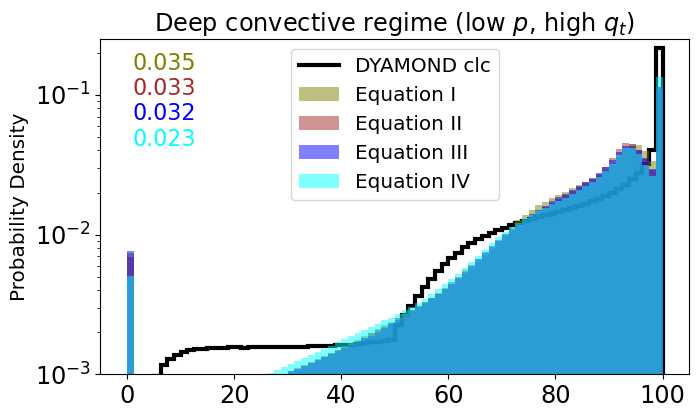

In [48]:
# Increase the general font size
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'xx-large'
mpl.rcParams['ytick.labelsize'] = 'xx-large'

plt.figure(figsize=(7.6, 4.35))
# plt.suptitle("Distributions on all validation data vs on the subset", fontsize=18, y=.91)

plot_titles = ['Cirrus regime (low $p$, low $q_t$)', 'Cumulus regime (high $p$, low $q_t$)', \
               'Deep convective regime (low $p$, high $q_t$)', 'Stratus regime (high $p$, high $q_t$)']

plot_title = plot_titles[regime - 1]

hist_data = {}
hist_preds = {}

axes = (0)

# Add new subplot iteratively
ax = plt.subplot(1, 1, 1)

BINS = 80
assert BINS == 80

plt.title(plot_title)
hist_data = plt.stairs(d_wang['Data_reg_%d_x'%(regime - 1)], d_wang['Data_reg_%d_y'%(regime - 1)], linewidth=3, color='black')
hist_eq_1 = plt.hist(preds_eq_1, linewidth=4, color='olive', density=True, fill=True, alpha=.5, bins=BINS)
hist_eq_2 = plt.hist(preds_eq_2, linewidth=4, color='brown', density=True, fill=True, alpha=.5, bins=BINS)
hist_eq_3 = plt.hist(preds_eq_3, linewidth=4, color='blue', density=True, fill=True, alpha=.5, bins=BINS)
hist_eq_4 = plt.hist(preds_eq_4, linewidth=4, color='cyan', density=True, fill=True, alpha=.5, bins=BINS)

eq_1_hel = hellinger(hist_eq_1[0], d_wang['Data_reg_%d_x'%(regime - 1)])
eq_2_hel = hellinger(hist_eq_2[0], d_wang['Data_reg_%d_x'%(regime - 1)])
eq_3_hel = hellinger(hist_eq_3[0], d_wang['Data_reg_%d_x'%(regime - 1)])
eq_4_hel = hellinger(hist_eq_4[0], d_wang['Data_reg_%d_x'%(regime - 1)])

plt.rc('font', size=16)
plt.text(1, 0.22 - 0.07, np.round(eq_1_hel, 3), color='olive')
plt.text(1, 0.2 - 0.1, np.round(eq_2_hel, 3), color='brown')
plt.text(1, 0.18 - 0.114, np.round(eq_3_hel, 3), color='blue')
plt.text(1, 0.16 - 0.117, np.round(eq_4_hel, 3), color='cyan')
plt.rc('font', size=10)

ax.legend(['DYAMOND clc', 'Equation I', 'Equation II', 'Equation III', 'Equation IV'], loc='upper center')

plt.ylabel('Probability Density')
# plt.ylim((0, 0.25))
plt.yscale('log')
plt.ylim([0.001, 0.25])
    
plt.savefig('regime_%d/evaluate_eqns.pdf'%regime)

**Print equations**

In [37]:
def round_expr(expr, num_digits=2):
    def format_number(n):
        if isinstance(n, (int, float)):
            return '{:.{}e}'.format(n, num_digits)
        elif isinstance(n, sp.Number):
            return '{:.{}e}'.format(n.evalf(), num_digits)
        else:
            return n

    converted_expr = expr.xreplace({
        n: sp.sympify(format_number(n)) for n in expr.atoms()
    })
    return converted_expr

dig = 3

In [38]:
# Equation 1
sp.simplify(eq_1.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

159.247947519391*RH - 1.76183417513861*T + (3.00756750601811*RH + (853.647555238175*RH_z + 0.0406507026413395)*(3874.99126286345*RH_z - 400716.975635751*RH_zz + 0.131533674697167) - 1.81209621695678)*(0.000160246329118757*p_s + (0.0332741193759742*T - 8.55362853373394)*(0.791831672192799*T - 203.552614230058) + 6.27728561573247) + 388.512893671281

In [39]:
round_expr(sp.simplify(eq_1.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

159.2*RH - 1.762*T + (3.008*RH + (853.6*RH_z + 0.04065)*(3875.0*RH_z - 400700.0*RH_zz + 0.1315) - 1.812)*(0.0001602*p_s + (0.03327*T - 8.554)*(0.7918*T - 203.6) + 6.277) + 388.5

In [40]:
# Equation 2
sp.simplify(eq_2.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

107.327663035986*RH - 1.1874158984155*T + ((9422.44680891898*RH - 5677.13947658794)*(0.00389005896675864*T - 1)**2 + 36.055973)*(3.00756750601811*RH - 0.015003888047575*T + 0.22545883*(3874.99126286345*RH_z + 0.184527111449995)*(3874.99126286345*RH_z - 400716.975635751*RH_zz + 0.131533674697167) + 2.04488594598376) + 272.816545857309

In [41]:
round_expr(sp.simplify(eq_2.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

107.3*RH - 1.187*T + ((9422.0*RH - 5677.0)*(0.00389*T - 1.0)**2.0 + 36.06)*(3.008*RH - 0.015*T + 0.2255*(3875.0*RH_z + 0.1845)*(3875.0*RH_z - 400700.0*RH_zz + 0.1315) + 2.045) + 272.8

In [42]:
# Equation 3
sp.simplify(eq_3.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

115.314026965519*RH - 1.27577276031121*T + ((10180.5015369807*RH - 6133.87672428668)*(0.00389005896675864*T - 1)**2 + 34.05128)*(3.00756750601811*RH - 0.0143263657527005*T - 0.21527791*(-3874.99126286345*RH_z + (400716.975635751*RH_zz + 0.0529934367528281)*(0.000160246329118757*p_s - 15.8046213842675) + 0.212300788550005)*(3874.99126286345*RH_z - 400716.975635751*RH_zz + 0.131533674697167) + 1.87071833036044) + 289.814854826522

In [43]:
round_expr(sp.simplify(eq_3.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

115.3*RH - 1.276*T + ((10180.0*RH - 6134.0)*(0.00389*T - 1.0)**2.0 + 34.05)*(3.008*RH - 0.01433*T - 0.2153*(-3875.0*RH_z + (400700.0*RH_zz + 0.05299)*(0.0001602*p_s - 15.8) + 0.2123)*(3875.0*RH_z - 400700.0*RH_zz + 0.1315) + 1.871) + 289.8

In [44]:
# Equation 4
sp.simplify(eq_4.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'}))

108.440772792666*RH - 1.1997307498189*T + (3.00756750601811*RH - 0.00819684971684756*T + 0.2463431*(3874.99126286345*RH_z - 400716.975635751*RH_zz + 0.131533674697167)*(3874.99126286345*RH_z - 0.0332741193759742*T + 8.73815564518393) + 0.295031152291696)*(-0.852996638578111*T + 0.000385937771837867*p_s + 25.6354384300857*(3.00756750601811*RH - 1.81209621695678)*(0.0332741193759742*T - 8.55362853373394)*(3.00756750601811*RH + 0.0332741193759742*T - 10.3657247506907) - 386727163181.82*(RH_zz + 1.32246548e-7)**2 + 216.130123913703) + 275.657087192345

In [45]:
round_expr(sp.simplify(eq_4.subs({'t':'T', 'qi':'q_i', 'qc':'q_c', 'rh':'RH', 'rh_z': 'RH_z', 'qc': 'q_c', 'pa_zz': 'p_zz', 'ps': 'p_s', 'rh_zz': 'RH_zz'})), dig)

108.4*RH - 1.2*T + (3.008*RH - 0.008197*T + 0.2463*(3875.0*RH_z - 400700.0*RH_zz + 0.1315)*(3875.0*RH_z - 0.03327*T + 8.738) + 0.295)*(-0.853*T + 0.0003859*p_s + 25.64*(3.008*RH - 1.812)*(0.03327*T - 8.554)*(3.008*RH + 0.03327*T - 10.37) - 386700000000.0*(RH_zz + 1.322e-7)**2.0 + 216.1) + 275.7